# **Locally Low Rank (LLR) Tutorial**

### Introduction:

  * LLR is an effective regularization technique
  * LLR enforces low rankness in the spatial-contrast dimension

### Authors:

  * Zhengguo Tan <zhengguo.tan@gmail.com>
  * Patrick A Liebig <patrick.liebig@siemens-healthineers.com>
  * Robin M Heidemann <robin.heidemann@siemens-healthineers.com>
  * Fredrik B Laun <Frederik.Laun@uk-erlangen.de>
  * Florian Knoll <florian.knoll@fau.de>

### References:

  * Cai JF, Candès EJ, Shen Z. [A singular value thresholding algorithm for matrix completion](https://doi.org/10.1137/080738970). SIAM J Optim 20:1956-1982 (2010).
  * Trzasko J, Manduca A. [Local versus global low-rank promotion in dynamic MRI series reconstruction](https://archive.ismrm.org/2011/4371.html). Proc Int Soc Magn Reson Med 19:4371 (2011).
  * Zhang T, Pauly J, Levesque I. [Accelerating parameter mapping with a locally low rank constraint](https://doi.org/10.1002/mrm.25161). 73:655-661 (2015).
  * Saucedo A, Lefkimmiatis S, Rangwala N, Sung K. [Improved computational efficiency of locally low rank MRI reconstruction using iterative random patch adjustments](https://doi.org/10.1109/TMI.2017.2659742). IEEE Trans Med Imaging 36:1209-1220 (2017).
  * Hu Y, Wang X, Tian Q, Yang G, Daniel B, McNab J, Hargreaves B. [Multi-shot diffusion-weighted MRI reconstruction with magnitude-based spatial-angular locally low-rank regularization (SPA-LLR)](https://doi.org/10.1002/mrm.28025). Magn Reson Med 83:1596-1607 (2020).

# 1. Setup

## Install SigPy

  * The original [SigPy](https://github.com/mikgroup/sigpy.git) was forked for the development of HD-MRI reconstruction and is available here: https://github.com/ZhengguoTan/sigpy.git

In [1]:
!git clone https://github.com/ZhengguoTan/sigpy.git

Cloning into 'sigpy'...
remote: Enumerating objects: 6447, done.
remote: Counting objects: 100% (1400/1400), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 6447 (delta 1282), reused 1254 (delta 1237), pack-reused 5047
Receiving objects: 100% (6447/6447), 3.78 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (4750/4750), done.


In [2]:
%cd /content/sigpy
!git log -1

/content/sigpy
commit 6057d19c28e88e642c2ea7dc9b72a61595781f0a (HEAD -> master, origin/master, origin/HEAD)
Author: Zhengguo Tan <zhengguo.tan@gmail.com>
Date:   Tue Dec 19 09:19:35 2023 +0100

    specify python 3.10 version


In [3]:
!pip install -e /content/sigpy

Obtaining file:///content/sigpy
  Preparing metadata (setup.py) ... done
  Running setup.py develop for sigpy


# 2. Load DWI

### Please be patient - downloading the data takes some time.

In [9]:
%%bash

mkdir -p /content/data && cd "$_"
pwd

RECORD='10474402'

wget -q https://zenodo.org/record/${RECORD}/files/0.5x0.5x2.0mm_R3x2_MUSE_slice_000_pat.h5

cd /content/sigpy

/content/data


In [10]:
DATA_DIR = '/content/data/'

In [11]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

import sigpy as sp
from sigpy import linop, thresh, util

import time

In [12]:
f = h5py.File(DATA_DIR + '0.5x0.5x2.0mm_R3x2_MUSE_slice_000_pat.h5')
DWI = np.squeeze(f['dwi_comb_muse'][:])
f.close()

N_diff, N_z, N_y, N_x = DWI.shape
# N_diff : numbeer of diffusion encodings (diff)
# N_z    : number of slices
# N_y    : number of phase encodings
# N_x    : number of readouts

print(DWI.shape)

(4, 2, 440, 440)


# 3. An Example on Converting DWI to Blocks (Spatial-Diffusion Matrices)

In [13]:
A = sp.linop.ArrayToBlocks(DWI.shape, (1, 3, 3), (1, 1, 1))

y = A(DWI)

print(y.shape)
print(A.num_blks)

(4, 2, 438, 438, 1, 3, 3)
[2, 438, 438]


In [14]:
def Fwd(ishape, block_shape=(1, 3, 3), block_stride=(1, 1, 1)):
    """
    Args:
        ishape: shape of the input array
    """

    A = linop.ArrayToBlocks(ishape, block_shape, block_stride)

    block_len = len(block_shape)

    oshape = [util.prod(A.ishape[:-block_len]),  # number of diff
              util.prod(A.num_blks),             # number of blocks
              util.prod(block_shape)
             ]

    R1 = linop.Reshape(oshape, A.oshape)
    R2 = linop.Transpose(R1.oshape, axes=(1, 0, 2))

    return R2 * R1 * A

In [15]:
# define the forward operator:
Tl = Fwd(DWI.shape)

yl = Tl(DWI)

print("> The shape of matrices for SVT: ", yl.shape)
print("> SVD is applied onto the 2D matrices in the right most 2 dimensions")

> The shape of matrices for SVT:  (383688, 4, 9)
> SVD is applied onto the 2D matrices in the right most 2 dimensions


# 4. SVD on Spatial-Diffusion Matrices

  * Larger block sizes lead to larger singular values

> block width and height is:  3
  The shape of matrices for SVT:  (383688, 4, 9)
  SVD takes  4.067281723022461  seconds
> block width and height is:  6
  The shape of matrices for SVT:  (378450, 4, 36)
  SVD takes  7.82343864440918  seconds
> block width and height is:  9
  The shape of matrices for SVT:  (373248, 4, 81)
  SVD takes  12.306796312332153  seconds
> block width and height is:  12
  The shape of matrices for SVT:  (368082, 4, 144)
  SVD takes  21.305824995040894  seconds


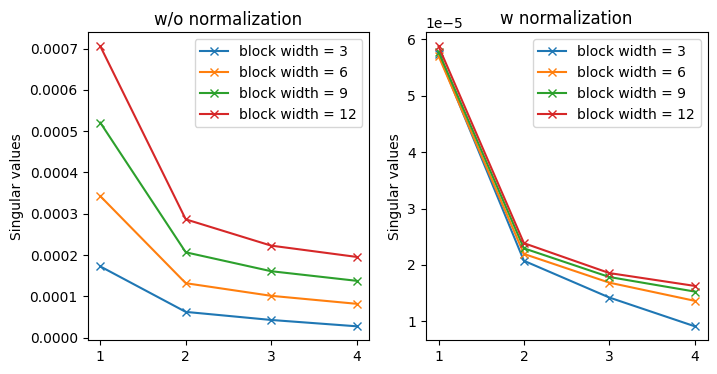

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

for b in [3, 6, 9, 12]: # block width

    start_time = time.time()

    print('> block width and height is: ', b)

    # define the forward operator for global low rank:
    T = Fwd(DWI.shape, block_shape=(1, b, b))

    # extract spatial-diffusion matrices
    y = T(DWI)

    print("  The shape of matrices for SVT: ", y.shape)

    u, s, vh = np.linalg.svd(y, full_matrices=False)

    end_time = time.time()

    print("  SVD takes ", end_time - start_time, ' seconds')

    # do not normalize the eigenvalues by the block width
    ax[0].plot(range(1, N_diff+1), np.mean(s, axis=0), '-x',
            label='block width = ' + str(b))

    # normalize the eigenvalues by the block width
    ax[1].plot(range(1, N_diff+1), np.mean(s, axis=0) / b, '-x',
            label='block width = ' + str(b))

ax[0].set_title('w/o normalization')
ax[1].set_title('w normalization')

for n in range(2):
  ax[n].set_xticks(range(1, N_diff+1))
  ax[n].set_ylabel('Singular values')
  ax[n].legend()

plt.show()

# 5. SVT based denoising

  * Note that the adjoint operator is needed to order blocks back to DWI

In [17]:
def denoising(input, block_shape=(1, 3, 3), lamda=0.001, normalization=False):

    # define the forward operator for global low rank:
    T = Fwd(input.shape, block_shape=block_shape)

    # extract spatial-diffusion matrices
    y = T(input)

    u, s, vh = np.linalg.svd(y, full_matrices=False)

    if normalization is True:
      s = s / block_shape[-1]

    # soft thresholding
    s_thresh = thresh.soft_thresh(lamda, s)

    if normalization is True:
      s_thresh = s_thresh * block_shape[-1]

    output = (u * s_thresh[..., None, :]) @ vh

    # here we need the adjoint operator
    output = T.H(output)

    return output

  * If the thresholding scaler (lamda) is kept constant, larger block size supplies less denoising effect in the output DWIs **without normalization**

In [18]:
DWI_b3 = denoising(DWI, block_shape=(1, 3, 3), lamda=0.00008)
DWI_b6 = denoising(DWI, block_shape=(1, 6, 6), lamda=0.00008)
DWI_b9 = denoising(DWI, block_shape=(1, 9, 9), lamda=0.00008)

DWI_disp = np.zeros_like(DWI, shape=[4, N_y, N_x])
DWI_disp[0] = DWI[1, 1, ...]
DWI_disp[1] = DWI_b3[1, 1, ...]
DWI_disp[2] = DWI_b6[1, 1, ...]
DWI_disp[3] = DWI_b9[1, 1, ...]

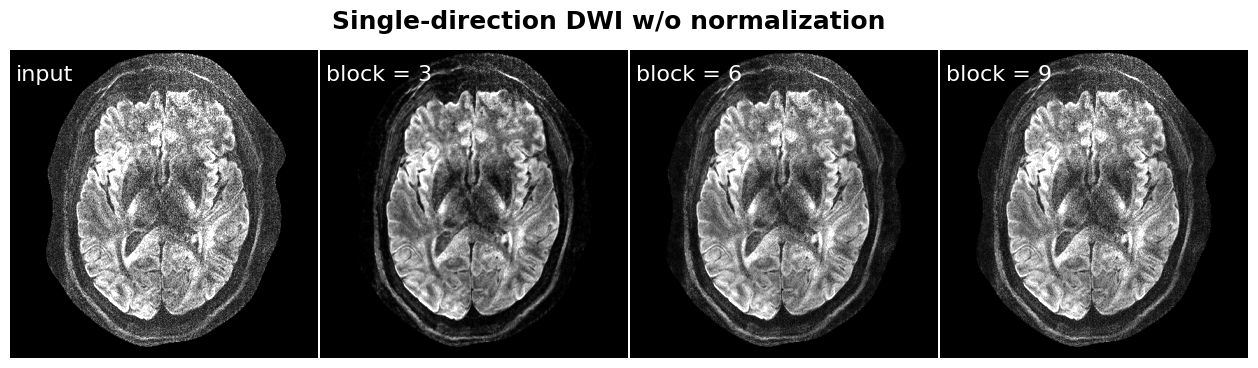

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

labels = ['input', 'block = 3', 'block = 6', 'block = 9']

for n in range(4):
    img = abs(np.flip(DWI_disp[n, :, :], axis=(0, 1)))
    ax[n].imshow(img, cmap='gray', vmin=0, vmax=0.0001)

    ax[n].text(int(0.02 * N_x), int(0.10 * N_y), labels[n],
               color='w', fontsize=16)

    ax[n].set_axis_off()

plt.suptitle('Single-direction DWI w/o normalization', fontsize=18, fontweight='bold')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

  * LLR **with normalization**.

In [20]:
DWI_b3_n = denoising(DWI, block_shape=(1, 3, 3), lamda=0.00002, normalization=True)
DWI_b6_n = denoising(DWI, block_shape=(1, 6, 6), lamda=0.00002, normalization=True)
DWI_b9_n = denoising(DWI, block_shape=(1, 9, 9), lamda=0.00002, normalization=True)

DWI_disp_n = np.zeros_like(DWI, shape=[4, N_y, N_x])
DWI_disp_n[0] = DWI[1, 1, ...]
DWI_disp_n[1] = DWI_b3_n[1, 1, ...]
DWI_disp_n[2] = DWI_b6_n[1, 1, ...]
DWI_disp_n[3] = DWI_b9_n[1, 1, ...]

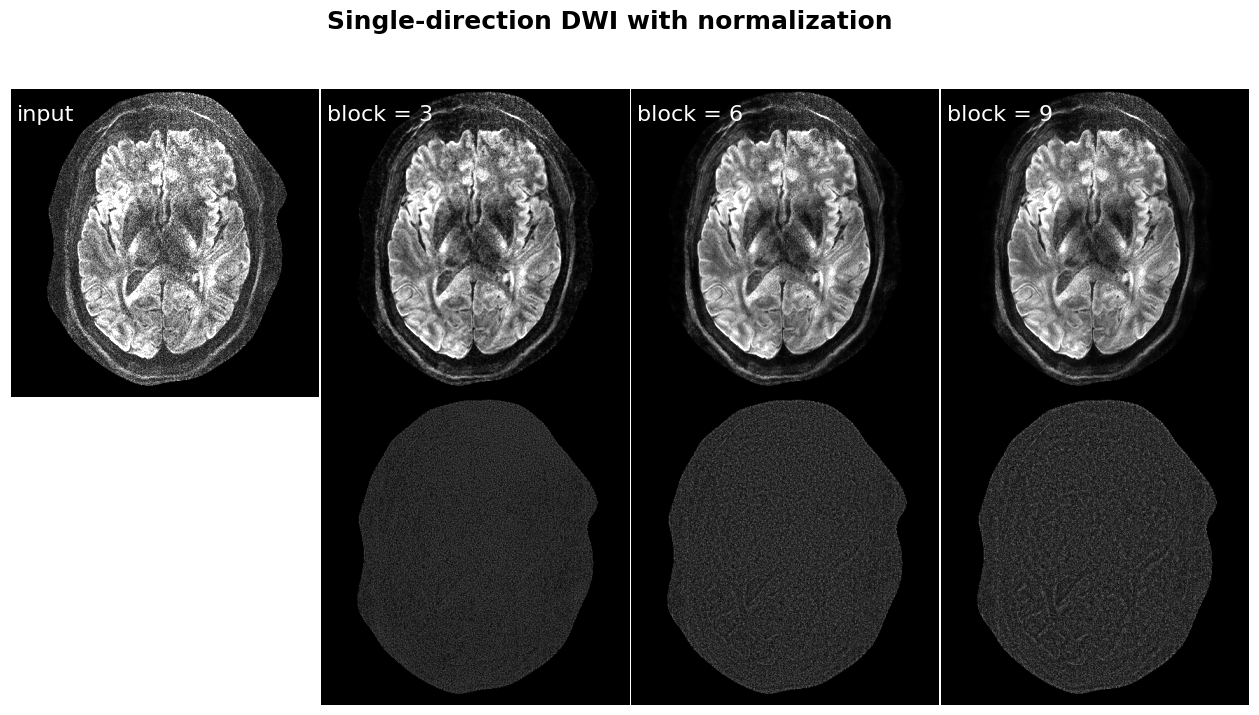

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

labels = ['input', 'block = 3', 'block = 6', 'block = 9']

for n in range(4):
    img = abs(np.flip(DWI_disp_n[n, :, :], axis=(0, 1)))
    ax[0][n].imshow(img, cmap='gray', vmin=0, vmax=0.0001)

    ax[0][n].text(int(0.02 * N_x), int(0.10 * N_y), labels[n],
               color='w', fontsize=16)

    ax[0][n].set_axis_off()
    ax[1][n].set_axis_off()

    if n > 0:
      img = abs(np.flip(DWI_disp_n[n] - DWI_disp_n[0], axis=(0, 1)))
      ax[1][n].imshow(img, cmap='gray', vmin=0, vmax=0.0001)

plt.suptitle('Single-direction DWI with normalization', fontsize=18, fontweight='bold')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Thank You for Your Attention!